In [1]:
# 기본 패키지
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import json

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
## 이미지에서 한글이 나오게 하는 설정
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

## 야후 파이낸스 패키지 ## pip install yfinance
import yfinance as yf

## 연준 패키지 ## pip install fredapi
from fredapi import Fred
## fred = Fred(api_key='Your API Key')

fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

In [2]:
## 사전 정의한 함수 모음
import graphModule as gm
import myfuncs as mf
from quant_functions import anal_funcs
import vidya as vd
import baseloader
import portfolio_obtimizer

In [3]:
## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

## Dataload

In [4]:
df_imp = pd.read_csv('trend_data.csv', index_col=0)
df_imp.index = pd.to_datetime(df_imp.index)
dataset = df_imp.copy()[:]
dataset = dataset[['TQQQ', 'SGOV']]

In [11]:
# 전략 실행
short_period = 2
long_period = 200
vidya = True
long_word = 'VIDYA' if vidya else 'SMA'
allocation = vd.VidyaAssetAllocation(data=dataset, cash_asset='SGOV', short_period=short_period, long_period=long_period,  alpha_factor=0.2, vidya=vidya)
portfolio, short_df, long_df = allocation.backtest()

In [12]:
result = dataset.copy()
result['Strategy'] = portfolio['Value']
## 판단 이후 시점부터
result = result[long_period:]
result = result/result.iloc[0] * 100

In [13]:
signal_df = dataset[['TQQQ']].copy()
signal_df[f'SMA_{short_period}'] = short_df['TQQQ']
signal_df[f'{long_word}_{long_period}'] = long_df['TQQQ']

In [14]:
## shock case
with open('shockCase.json', encoding='utf-8') as f:
    shock_cases = json.load(f)
## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

highlight_periods = [(shock_cases['1차오일쇼크_t0'], shock_cases['1차오일쇼크_t1']),
                     (shock_cases['2차오일쇼크_t0'], shock_cases['2차오일쇼크_t1']),
                     (shock_cases['물가충격_t0'], shock_cases['물가충격_t1']),
                     (shock_cases['걸프전_t0'], shock_cases['걸프전_t1']),
                     (shock_cases['닷컴버블_t0'], shock_cases['닷컴버블_t1']),
                     (shock_cases['금융위기_t0'], shock_cases['금융위기_t1']),
                     (shock_cases['코로나_t0'], shock_cases['코로나_t1'])]

# color 설정
colors = [mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub'], mycolors['color_norm2'], mycolors['color_cont2']]

In [20]:
def trend_cross_plot(df, highlight_periods=highlight_periods, colors=[mycolors['color_norm3'], mycolors['color_norm2'], mycolors['color_cont']], title=True, yscale='log'):
    """
    Plots a cumulative return graph for short and long trends with directional arrow markers at crossover points.

    Parameters:
        df (DataFrame): A DataFrame containing date-indexed asset data.
        highlight_periods (list of tuples): List of (start_date, end_date) tuples to highlight on the graph.
        colors (list): List of colors for the lines.
    """
    assets = df.columns
    data = df[assets].copy()
    _df = data.reset_index()
    _df = _df.melt(id_vars='Date', value_vars=_df.columns, var_name='Ticker', value_name='Value')

    # 색상 수 조정
    if len(colors) > len(assets):
        colors = colors[:len(assets)]

    fig, ax = plt.subplots(figsize=(12, 8))
    sns.lineplot(data=_df, x='Date', y='Value', hue='Ticker', palette=colors, linestyle='-', linewidth=2, ax=ax, zorder=1)

    # 교차점 계산
    cross = np.sign(df[assets[1]] - df[assets[2]]).diff().fillna(0)

    # 상향 돌파 (short > long)
    upward_cross = cross[cross > 0].index
    # 하향 돌파 (short < long)
    downward_cross = cross[cross < 0].index

    # 교차점 표시 (상향 돌파)
    ax.scatter(upward_cross, df.loc[upward_cross, assets[2]], color='green', marker='^', s=100, label='Golden Cross (▲)', zorder=5)
    # 교차점 표시 (하향 돌파)
    ax.scatter(downward_cross, df.loc[downward_cross, assets[2]], color='red', marker='v', s=100, label='Dead Cross (▼)', zorder=5)

    if title:
        ax.set_title(f'Trends with Cross Points ({data.index[0].year}~{data.index[-1].year})', fontsize=22, fontweight='bold')

    ax.set_ylabel(f"", fontsize=14, labelpad=-50, loc="top", rotation=0)
    ax.set_xlabel("Date", fontsize=14)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)

    if yscale == 'log':
        ax.set_yscale('log')

    ax.grid(color="gray", linestyle="--", linewidth=0.7, alpha=0.7)

    x_min, x_max = data.index.min(), data.index.max()
    if highlight_periods:
        for start, end in highlight_periods:
            start_date = pd.to_datetime(start)
            end_date = pd.to_datetime(end)
            if start_date > x_max or end_date < x_min:
                continue
            ax.axvspan(start_date, end_date, facecolor="gray", alpha=0.30)

    plt.tight_layout()
    plt.legend()
    plt.show()


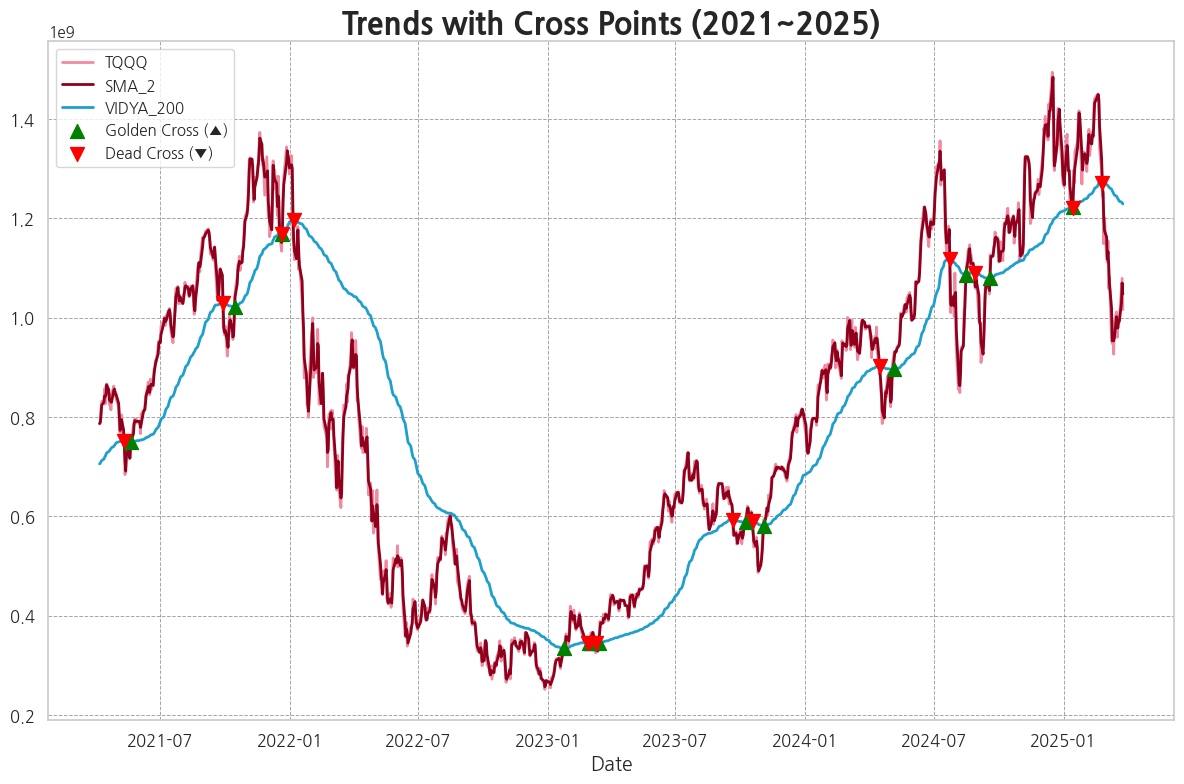

In [22]:
trend_cross_plot(signal_df.tail(1000), yscale='linear')